In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score, precision_score
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif, f_classif
from lazypredict.Supervised import LazyClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import StackingClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMRegressor, LGBMClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

In [2]:
#importing the datasets
train = pd.read_csv("Train.csv")
test = pd.read_csv("Test.csv")
samplesubmission = pd.read_csv("sample_submission.csv")

train.head()

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,SAINT-LOUIS,K > 24 month,17000.00,32.00,18000.00,6000.00,34.00,NaN,97.00,355.00,6.00,NaN,NaN,NO,62,All-net 500F=2000F;5d,35.00,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,NaN,K > 24 month,4300.00,29.00,4427.00,1476.00,37.00,1764.00,8.00,3.00,0.00,NaN,2.00,NO,40,"Data: 100 F=40MB,24H",22.00,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,TAMBACOUNDA,K > 24 month,1500.00,3.00,1500.00,500.00,3.00,NaN,30.00,30.00,NaN,NaN,NaN,NO,32,All-net 500F=2000F;5d,3.00,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,FATICK,K > 24 month,1500.00,3.00,2497.00,832.00,4.00,0.00,159.00,45.00,19.00,NaN,NaN,NO,18,On net 200F=Unlimited _call24H,3.00,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,FATICK,K > 24 month,NaN,NaN,498.00,166.00,3.00,1.00,1.00,3.00,NaN,NaN,NaN,NO,50,NaN,NaN,0


In [3]:
train.shape

(400000, 19)

In [4]:
test.shape

(100000, 18)

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,259723.00,5522.97,7099.64,20.00,1000.00,3000.00,7300.00,226550.00
FREQUENCE_RECH,259723.00,11.50,13.28,1.00,2.00,6.00,15.00,133.00
REVENUE,265337.00,5505.49,7175.80,1.00,1000.00,3000.00,7340.00,233413.00
ARPU_SEGMENT,265337.00,1835.17,2391.93,0.00,333.00,1000.00,2447.00,77804.00
FREQUENCE,265337.00,13.95,14.68,1.00,3.00,9.00,19.00,91.00
DATA_VOLUME,203146.00,3369.76,12281.87,0.00,0.00,267.00,2925.00,934576.00
ON_NET,254181.00,275.92,873.59,0.00,5.00,27.00,155.00,45011.00
ORANGE,233683.00,95.53,204.73,0.00,7.00,29.00,99.00,6788.00
TIGO,160614.00,23.13,63.06,0.00,2.00,6.00,20.00,2758.00
ZONE1,31690.00,7.87,35.64,0.00,0.00,1.00,3.00,1657.00


In [6]:
test.describe().T

,count,mean,std,min,25%,50%,75%,max
MONTANT,65049.00,5545.61,7123.96,25.00,1000.00,3000.00,7400.00,201500.00
FREQUENCE_RECH,65049.00,11.55,13.27,1.00,2.00,7.00,16.00,120.00
REVENUE,66510.00,5518.34,7177.84,1.00,1000.00,3000.00,7399.00,181135.00
ARPU_SEGMENT,66510.00,1839.45,2392.61,0.00,333.00,1000.00,2466.00,60378.00
FREQUENCE,66510.00,13.98,14.66,1.00,3.00,9.00,20.00,91.00
DATA_VOLUME,50662.00,3357.43,10515.26,0.00,0.00,268.00,2923.00,474262.00
ON_NET,63617.00,279.37,870.77,0.00,5.00,27.00,157.00,24887.00
ORANGE,58800.00,94.90,201.96,0.00,7.00,28.00,99.00,5695.00
TIGO,40212.00,23.46,66.93,0.00,2.00,6.00,20.00,3083.00
ZONE1,7680.00,8.37,40.82,0.00,0.00,1.00,4.00,1366.00


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         400000 non-null  object 
 1   REGION          242480 non-null  object 
 2   TENURE          400000 non-null  object 
 3   MONTANT         259723 non-null  float64
 4   FREQUENCE_RECH  259723 non-null  float64
 5   REVENUE         265337 non-null  float64
 6   ARPU_SEGMENT    265337 non-null  float64
 7   FREQUENCE       265337 non-null  float64
 8   DATA_VOLUME     203146 non-null  float64
 9   ON_NET          254181 non-null  float64
 10  ORANGE          233683 non-null  float64
 11  TIGO            160614 non-null  float64
 12  ZONE1           31690 non-null   float64
 13  ZONE2           25513 non-null   float64
 14  MRG             400000 non-null  object 
 15  REGULARITY      400000 non-null  int64  
 16  TOP_PACK        232671 non-null  object 
 17  FREQ_TOP_P

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         100000 non-null  object 
 1   REGION          60707 non-null   object 
 2   TENURE          100000 non-null  object 
 3   MONTANT         65049 non-null   float64
 4   FREQUENCE_RECH  65049 non-null   float64
 5   REVENUE         66510 non-null   float64
 6   ARPU_SEGMENT    66510 non-null   float64
 7   FREQUENCE       66510 non-null   float64
 8   DATA_VOLUME     50662 non-null   float64
 9   ON_NET          63617 non-null   float64
 10  ORANGE          58800 non-null   float64
 11  TIGO            40212 non-null   float64
 12  ZONE1           7680 non-null    float64
 13  ZONE2           6422 non-null    float64
 14  MRG             100000 non-null  object 
 15  REGULARITY      100000 non-null  int64  
 16  TOP_PACK        58297 non-null   object 
 17  FREQ_TOP_PA

In [9]:
(train.isna().sum()/len(train)) * 100

user_id           0.00
REGION           39.38
TENURE            0.00
MONTANT          35.07
FREQUENCE_RECH   35.07
REVENUE          33.67
ARPU_SEGMENT     33.67
FREQUENCE        33.67
DATA_VOLUME      49.21
ON_NET           36.45
ORANGE           41.58
TIGO             59.85
ZONE1            92.08
ZONE2            93.62
MRG               0.00
REGULARITY        0.00
TOP_PACK         41.83
FREQ_TOP_PACK    41.83
CHURN             0.00
dtype: float64

In [10]:
(test.isna().sum()/len(test)) * 100

user_id           0.00
REGION           39.29
TENURE            0.00
MONTANT          34.95
FREQUENCE_RECH   34.95
REVENUE          33.49
ARPU_SEGMENT     33.49
FREQUENCE        33.49
DATA_VOLUME      49.34
ON_NET           36.38
ORANGE           41.20
TIGO             59.79
ZONE1            92.32
ZONE2            93.58
MRG               0.00
REGULARITY        0.00
TOP_PACK         41.70
FREQ_TOP_PACK    41.70
dtype: float64

In [11]:
colencode = ["REGION", "TOP_PACK", "TENURE", "MRG",]

label_encode = LabelEncoder()
for col in colencode:
    train[col] = label_encode.fit_transform(train[col])

In [12]:
train

,user_id,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,DATA_VOLUME,ON_NET,ORANGE,TIGO,ZONE1,ZONE2,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK,CHURN
0,dcf68cc2fb515ccad7d8b9b3bd80ee2a4b270063,9,7,17000.00,32.00,18000.00,6000.00,34.00,NaN,97.00,355.00,6.00,NaN,NaN,0,62,15,35.00,0
1,71c44b5ba328db5c4192a80f7cf8f244d9350ed0,14,7,4300.00,29.00,4427.00,1476.00,37.00,1764.00,8.00,3.00,0.00,NaN,2.00,0,40,25,22.00,0
2,ce46411b1526c94f20a383b8cb188f8d27f82a0a,11,7,1500.00,3.00,1500.00,500.00,3.00,NaN,30.00,30.00,NaN,NaN,NaN,0,32,15,3.00,0
3,f467cdb6669818373c26c2bad44e01ba66f97d21,2,7,1500.00,3.00,2497.00,832.00,4.00,0.00,159.00,45.00,19.00,NaN,NaN,0,18,84,3.00,0
4,ec45e1a1888a32b5dcce0954cfec20c6e037db31,2,7,NaN,NaN,498.00,166.00,3.00,1.00,1.00,3.00,NaN,NaN,NaN,0,50,111,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,a892ad4ed0eda8dc721733200c47147763b183ec,11,7,700.00,2.00,704.00,235.00,3.00,NaN,12.00,14.00,NaN,NaN,NaN,0,46,15,1.00,0
399996,13daa3a651bf0192a413b339c4766aeafc6d1636,14,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,14,111,NaN,0
399997,767f596aee426962f7d92f4de8d7b232cdc17568,14,7,700.00,2.00,699.00,233.00,5.00,237.00,1.00,NaN,NaN,NaN,NaN,0,15,25,3.00,0
399998,b831e4d3b59a1e294e9e0a2aab391bc12d50845c,14,7,NaN,NaN,9.00,3.00,1.00,0.00,NaN,0.00,NaN,NaN,NaN,0,5,111,NaN,1


In [13]:
x = train.drop(["user_id", "DATA_VOLUME", "TIGO", "ZONE1", "ZONE2", "CHURN"], axis = 1)

y = train["CHURN"]

x

,REGION,TENURE,MONTANT,FREQUENCE_RECH,REVENUE,ARPU_SEGMENT,FREQUENCE,ON_NET,ORANGE,MRG,REGULARITY,TOP_PACK,FREQ_TOP_PACK
0,9,7,17000.00,32.00,18000.00,6000.00,34.00,97.00,355.00,0,62,15,35.00
1,14,7,4300.00,29.00,4427.00,1476.00,37.00,8.00,3.00,0,40,25,22.00
2,11,7,1500.00,3.00,1500.00,500.00,3.00,30.00,30.00,0,32,15,3.00
3,2,7,1500.00,3.00,2497.00,832.00,4.00,159.00,45.00,0,18,84,3.00
4,2,7,NaN,NaN,498.00,166.00,3.00,1.00,3.00,0,50,111,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,11,7,700.00,2.00,704.00,235.00,3.00,12.00,14.00,0,46,15,1.00
399996,14,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,14,111,NaN
399997,14,7,700.00,2.00,699.00,233.00,5.00,1.00,NaN,0,15,25,3.00
399998,14,7,NaN,NaN,9.00,3.00,1.00,NaN,0.00,0,5,111,NaN


In [14]:
y

0         0
1         0
2         0
3         0
4         0
         ..
399995    0
399996    0
399997    0
399998    1
399999    0
Name: CHURN, Length: 400000, dtype: int64

In [15]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [16]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test= train_test_split (x, y, test_size=0.3,random_state=42)

from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split


# Create an instance of LazyClassifier
classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)

# Fit the classifier and get the models and predictions
models, predictions = classifier.fit(x_train, x_test, y_train, y_test)


In [17]:
classifier = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
models, predictions = classifier.fit(x_train, x_test, y_train, y_test)

 97%|█████████▋| 28/29 [4:38:12<41:38, 2498.43s/it]  

[LightGBM] [Info] Number of positive: 52424, number of negative: 227576
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1773
[LightGBM] [Info] Number of data points in the train set: 280000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.187229 -> initscore=-1.468120
[LightGBM] [Info] Start training from score -1.468120


100%|██████████| 29/29 [4:38:20<00:00, 575.86s/it] 


In [18]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
PassiveAggressiveClassifier,0.82,0.85,0.85,0.84,2.08
Perceptron,0.79,0.83,0.83,0.81,1.85
SGDClassifier,0.86,0.83,0.83,0.87,2.85
NearestCentroid,0.76,0.82,0.82,0.79,0.56
GaussianNB,0.80,0.82,0.82,0.81,1.99
QuadraticDiscriminantAnalysis,0.81,0.81,0.81,0.83,1.75
BernoulliNB,0.79,0.81,0.81,0.81,1.01
LogisticRegression,0.87,0.81,0.81,0.88,1.60
LinearSVC,0.87,0.81,0.81,0.87,119.29


In [27]:
from sklearn.impute import SimpleImputer
from sklearn.linear_model import PassiveAggressiveClassifier

# Identify missing values in x_train and x_test
missing_cols_train = x_train.columns[x_train.isnull().any()]
missing_cols_test = x_test.columns[x_test.isnull().any()]

# Apply imputation to handle missing values
imputer = SimpleImputer(strategy="mean")  # You can choose other strategies as well
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.transform(x_test)



In [28]:
# Create and fit the model on your training data with imputed values
pac = PassiveAggressiveClassifier()
pac.fit(x_train_imputed, y_train)

# Make predictions on the test data
pac_preds = pac.predict(x_test_imputed)

In [21]:
pac_preds

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [22]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

# Calculate accuracy
accuracy = accuracy_score(y_test, pac_preds)

# Calculate F1 score
f1score = f1_score(y_test, pac_preds)

# Calculate recall score
recall = recall_score(y_test, pac_preds)

# Calculate precision score
precision = precision_score(y_test, pac_preds)

print("Accuracy:", accuracy)
print("F1 Score:", f1score)
print("Recall Score:", recall)
print("Precision Score:", precision)

Accuracy: 0.8131833333333334
F1 Score: 0.0014253897550111359
Recall Score: 0.0007136485280999108
Precision Score: 0.5333333333333333


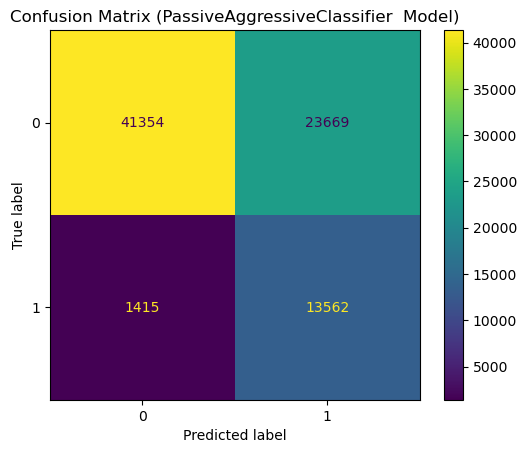

In [40]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=pac_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix)
cm_display.plot()
plt.title("Confusion Matrix (PassiveAggressiveClassifier  Model)");

SGDClassifier

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.impute import SimpleImputer

# Split your data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.transform(x_test)

# Create and train the SGDClassifier
sgd = SGDClassifier(loss='hinge', alpha=0.01, max_iter=1000, random_state=42)
sgd.fit(x_train_imputed, y_train)

# Make predictions on the test set
sgd_preds = sgd.predict(x_test_imputed)

# Calculate accuracy
accuracy = accuracy_score(y_test, sgd_preds)

# Calculate F1 score
f1score = f1_score(y_test, sgd_preds)

# Calculate recall score
recall = recall_score(y_test, sgd_preds)

# Calculate precision score
precision = precision_score(y_test, sgd_preds)

print("Accuracy:", accuracy)
print("F1 Score:", f1score)
print("Recall Score:", recall)
print("Precision Score:", precision)


Accuracy: 0.4371
F1 Score: 0.3936554101362633
Recall Score: 0.9760299125325499
Precision Score: 0.24654669342733299


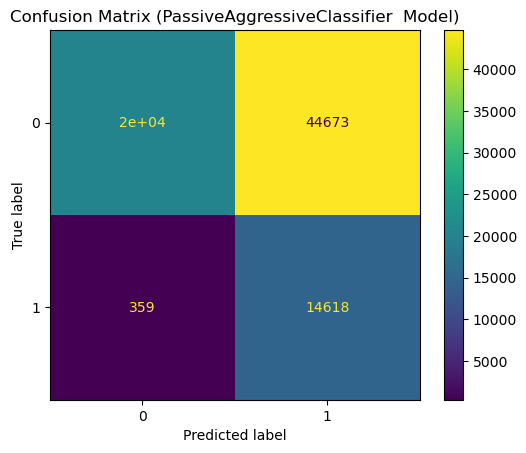

In [39]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=sgd_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix)
cm_display.plot()
plt.title("Confusion Matrix (PassiveAggressiveClassifier  Model)");

from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming x_train, x_test, y_train, y_test are already loaded

# Impute missing values|
imputer = SimpleImputer(strategy='mean')
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.transform(x_test)

# Scale the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
x_test_scaled = scaler.transform(x_test_imputed)

# Create models
model1 = RandomForestClassifier()
model2 = PassiveAggressiveClassifier()

# Create a voting classifier
voting_models = VotingClassifier(estimators=[("random_forest", model1), ("passive_aggressive", model2)])

# Train and evaluate
cross_val_scores = cross_val_score(voting_models, x_train_scaled, y_train, cv=10)
voting_models.fit(x_train_scaled, y_train)
ensemble_pred = voting_models.predict(x_test_scaled)

print("Cross-validation scores:", cross_val_scores)
print("Ensemble predictions:", ensemble_pred)


In [30]:
from sklearn.ensemble import RandomForestRegressor

# Create and fit the model on your training data with imputed values
rf = RandomForestRegressor()
rf.fit(x_train_imputed, y_train)

# Make predictions on the test data
rf_preds = rf.predict(x_test_imputed)

In [31]:
rf_preds

array([0.        , 0.        , 0.15      , ..., 0.61594161, 0.43      ,
       0.        ])

In [36]:
# Check data types
print("y_test data type:", type(y_test))
print("rf_preds data type:", type(rf_preds))

# Check unique values
print("Unique values in y_test:", np.unique(y_test))
print("Unique values in rf_preds:", np.unique(rf_preds))

y_test data type: <class 'pandas.core.series.Series'>
rf_preds data type: <class 'numpy.ndarray'>
Unique values in y_test: [0 1]
Unique values in rf_preds: [0.00000000e+00 1.06382979e-04 1.41843972e-04 ... 9.96250000e-01
 9.98387097e-01 1.00000000e+00]


In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.impute import SimpleImputer

# Split your data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Impute missing values
imputer = SimpleImputer(strategy='mean')
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.transform(x_test)

# Create and train the RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_imputed, y_train)

# Make predictions on the test set
rf_preds = rf.predict(x_test_imputed)

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_preds)

# Calculate F1 score
f1score = f1_score(y_test, rf_preds)

# Calculate recall score
recall = recall_score(y_test, rf_preds)

# Calculate precision score
precision = precision_score(y_test, rf_preds)

print("Accuracy:", accuracy)
print("F1 Score:", f1score)
print("Recall Score:", recall)
print("Precision Score:", precision)


Accuracy: 0.874025
F1 Score: 0.6604904999326237
Recall Score: 0.6545369566668893
Precision Score: 0.6665533419460121


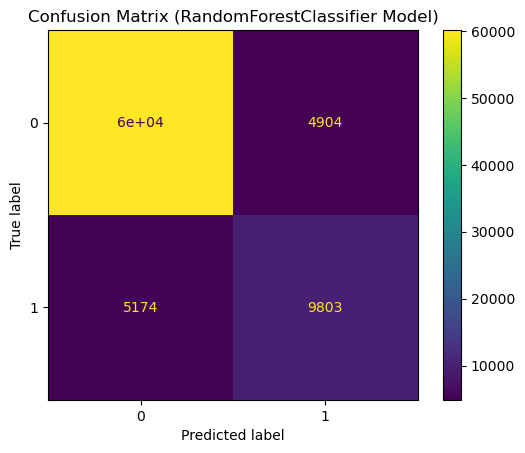

In [41]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=rf_preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix)
cm_display.plot()
plt.title("Confusion Matrix (RandomForestClassifier Model)");

#### Ensemble Learning

In [42]:
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np

# Assuming x_train, x_test, y_train, y_test are already loaded

# Impute missing values|
imputer = SimpleImputer(strategy='mean')
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.transform(x_test)

# Scale the features
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_imputed)
x_test_scaled = scaler.transform(x_test_imputed)

# Create models
model1 = RandomForestClassifier()
model2 = PassiveAggressiveClassifier()

# Create a voting classifier
voting_models = VotingClassifier(estimators=[("random_forest", model1), ("passive_aggressive", model2)])

# Train and evaluate
cross_val_scores = cross_val_score(voting_models, x_train_scaled, y_train, cv=10)
voting_models.fit(x_train_scaled, y_train)
ensemble_pred = voting_models.predict(x_test_scaled)

print("Cross-validation scores:", cross_val_scores)
print("Ensemble predictions:", ensemble_pred)

print(acc_scores)
print(f1Scores)
print(class_report_ensemble1)


Cross-validation scores: [0.8129375  0.81296875 0.8754375  0.87615625 0.8804375  0.87909375
 0.8134375  0.8665     0.8690625  0.87646875]
Ensemble predictions: [0 0 0 ... 0 0 0]


In [45]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

acc_scores = accuracy_score(y_test, ensemble_pred)
f1Scores = f1_score(y_test, ensemble_pred)
class_report_ensemble = classification_report(y_test, ensemble_pred)
print(acc_scores)
print(f1Scores)
print(class_report_ensemble)


0.8131625
0.0071736964463633346
              precision    recall  f1-score   support

           0       0.81      1.00      0.90     65023
           1       0.69      0.00      0.01     14977

    accuracy                           0.81     80000
   macro avg       0.75      0.50      0.45     80000
weighted avg       0.79      0.81      0.73     80000



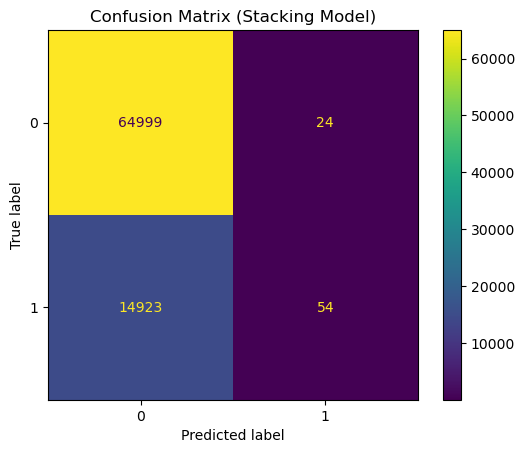

In [47]:
confuison_matrix = confusion_matrix(y_true=y_test, y_pred=ensemble_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confuison_matrix)
cm_display.plot()
plt.title("Confusion Matrix (Stacking Model)");

In [48]:
samplesubmission.head()

,user_id,CHURN
0,af900d87e73b7ff6509d2203df4704a98aa5f2a6,0
1,5335efd940280b82143272275637d1e65d37eadb,0
2,a581f4fa08677c26f83f643248c667e241043086,0
3,64f67177d0775262b8087a9e2e3b8061b6324ae6,0
4,0d6009a4594c4be22449b8d9cc01a0bcea98faea,0


In [50]:
samplesubmission['CHURN'] =  np.mean(ensemble_pred, axis = 0)

In [51]:
samplesubmission.to_csv('CHURN FORECATING.csv', index=False)